# Fetching the dataset for cityscapes
Cityscapes can be used with tensorflow datasets, but can't be downloaded from it
## Aquiring the data
1. Register an account at https://www.cityscapes-dataset.com/register/
2. You will get a mail saying you have access once they approve of your account as well as instructions on how to login
3. After loggin in, dowmload leftImg8bit_trainvaltest.zip and gtFine_trainvaltest.zip
4. Upload then to HCC
## Setting it to work with tensorflow datasets
Follow instructions at https://www.tensorflow.org/datasets/catalog/cityscapes
You only need to set it up for ```cityscapes/semantic_segmentation (default config)```

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import math

import tensorflow_datasets as tfds


In [17]:
train_ds = tfds.load('cityscapes', data_dir="./tensorflow_datasets/", split='train[0:90%]', shuffle_files=True)
val_ds = tfds.load('cityscapes', data_dir="./tensorflow_datasets/", split='train[90%:]', shuffle_files=True)
test_ds = tfds.load('cityscapes', data_dir="./tensorflow_datasets/", split='validation')

In [18]:
from tqdm import tqdm
from collections import defaultdict
import tensorflow as tf
# labels.py was downloaded form https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
# The repo is by authors of cityscapes and provides helpful utilities
from labels import id2label, labels
import cv2

train_id_to_name = {}
train_id_to_color = {}

IGNORE_TRAIN_IDS =  (-1, 255)

for label in labels:
    if label.trainId not in IGNORE_TRAIN_IDS:
        train_id_to_name[label.trainId] = label.name
        train_id_to_color[label.trainId] = label.color

# Add void class
VOID_CLASS = len(train_id_to_color)
train_id_to_name[VOID_CLASS] = 'void'
train_id_to_color[VOID_CLASS] = (0, 0, 0)

In [19]:
train_id_to_color

{0: (128, 64, 128),
 1: (244, 35, 232),
 2: (70, 70, 70),
 3: (102, 102, 156),
 4: (190, 153, 153),
 5: (153, 153, 153),
 6: (250, 170, 30),
 7: (220, 220, 0),
 8: (107, 142, 35),
 9: (152, 251, 152),
 10: (70, 130, 180),
 11: (220, 20, 60),
 12: (255, 0, 0),
 13: (0, 0, 142),
 14: (0, 0, 70),
 15: (0, 60, 100),
 16: (0, 80, 100),
 17: (0, 0, 230),
 18: (119, 11, 32),
 19: (0, 0, 0)}

In [20]:

def data_generator(ds, batch_size, resolution):
    resolution = (resolution[1], resolution[0]) # NUMPY CONVENTION :(
    for data in ds.batch(batch_size):
        label_batch = data["segmentation_label"].numpy()
        for label in labels:
            if label.trainId in IGNORE_TRAIN_IDS:
                label_batch[label_batch==label.id] = VOID_CLASS
            else:
                label_batch[label_batch==label.id] = label.trainId
        image = np.stack([cv2.resize(i.numpy(), resolution) for i in data["image_left"]])
        mask = np.stack([cv2.resize(i, resolution) for i in label_batch])
        yield image, mask



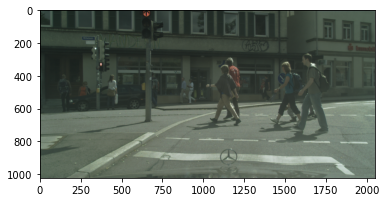

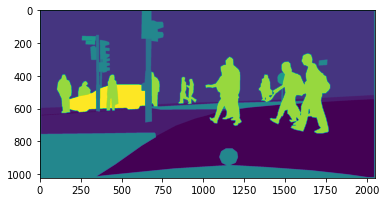

In [21]:
def show_figure(data_gen):
        i = next(data_gen)

        plt.imshow(i[0][0]);
        plt.figure()
        plt.imshow(i[1][0]);

show_figure(data_generator(train_ds, 1, (1024, 2048)))

In [22]:
train_id_to_color

{0: (128, 64, 128),
 1: (244, 35, 232),
 2: (70, 70, 70),
 3: (102, 102, 156),
 4: (190, 153, 153),
 5: (153, 153, 153),
 6: (250, 170, 30),
 7: (220, 220, 0),
 8: (107, 142, 35),
 9: (152, 251, 152),
 10: (70, 130, 180),
 11: (220, 20, 60),
 12: (255, 0, 0),
 13: (0, 0, 142),
 14: (0, 0, 70),
 15: (0, 60, 100),
 16: (0, 80, 100),
 17: (0, 0, 230),
 18: (119, 11, 32),
 19: (0, 0, 0)}

In [23]:
import numpy as np
from classification_models.tfkeras import Classifiers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os


def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape

    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output



def DeeplabV3PlusResnet18(image_size, num_classes):
    model_input = keras.Input(shape=(image_size[0], image_size[1], 3))
    
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    resnet18 = ResNet18(weights='imagenet',include_top=False, input_tensor=model_input)
    
    x = resnet18.get_layer("relu1").output
    x = DilatedSpatialPyramidPooling(x)


    input_a = layers.UpSampling2D(
        size=(image_size[0] // 4 // x.shape[1], image_size[1] // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    
    input_b = resnet18.get_layer("stage2_unit1_relu1").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
    
    input_a = tf.image.resize_with_crop_or_pad(input_a, input_b.shape[1], input_b.shape[2])
    
    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size[0] // x.shape[1], image_size[1] // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same",activation="softmax")(x)
    
    model = keras.Model(inputs=model_input, outputs=model_output)
    
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    
    model.compile(
                 optimizer=keras.optimizers.Adam(learning_rate=0.001),
                 loss=loss,
                 metrics=["accuracy"])
    return model


def DeeplabV3PlusResnet50(image_size, num_classes):
    model_input = keras.Input(shape=(image_size[0], image_size[1], 3))
    
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    
    x = resnet50.get_layer("conv5_block3_out").output
    x = DilatedSpatialPyramidPooling(x)


    input_a = layers.UpSampling2D(
        size=(image_size[0] // 4 // x.shape[1], image_size[1] // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    
    input_b = resnet50.get_layer("conv2_block3_out").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
    
    input_a = tf.image.resize_with_crop_or_pad(input_a, input_b.shape[1], input_b.shape[2])
    
    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size[0] // x.shape[1], image_size[1] // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same",activation="softmax")(x)
    
    model = keras.Model(inputs=model_input, outputs=model_output)
    
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    
    model.compile(
                 optimizer=keras.optimizers.Adam(learning_rate=0.001),
                 loss=loss,
                 metrics=["accuracy"])
    return model

In [24]:
def repeated_data_generator(data_generator, **args):
    while True:
        yield from data_generator(**args)
    


In [25]:
import json

def plot_trainning_history(history):
    epochs=len(history["loss"])
    plt.figure(figsize=(12,9), dpi=60)

    for i, metric in enumerate(["accuracy", "loss"]):
        plt.subplot(1, 2, i+1)

        plt.plot(range(1,epochs+1), history[f'val_{metric}'],"r--", alpha=1.0, linewidth=2.0,label='validation')
        plt.plot(range(1,epochs+1), history[metric],"b--", alpha=1.0, linewidth=3.0,label='training')
        plt.legend(loc=0)
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.xlim([1,epochs+1])
        plt.grid(True)
        plt.title(f"Model {metric.capitalize()}")

    return plt

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def decode_segmentation_masks(mask, color_mapping):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    
    for class_id, class_color in color_mapping.items():
        idx = mask == class_id
        r[idx] = class_color[0]
        g[idx] = class_color[1]
        b[idx] = class_color[2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def visualize_np_array(array):
    from matplotlib import pyplot as plt
    plt.imshow(array, interpolation='nearest')
    plt.show()

def predict_and_visualize(model, testing_image):
    image, mask = testing_image
    predicted = np.argmax(model.predict(image), axis=3)[0]
    acutal = mask[0]
    print("Image Accuracy", np.sum(predicted==acutal)/np.size(acutal))

    visualize_np_array(image[0])
    visualize_np_array(decode_segmentation_masks(acutal, train_id_to_color))
    visualize_np_array(decode_segmentation_masks(predicted, train_id_to_color))



def calculate_metrics(model,test_ds, resolution):
    Y_actual = []
    Y_pred = []

    for data in tqdm(data_generator(test_ds, 4, resolution)):
        image, mask = data
        Y_pred.append( np.argmax(model.predict(image), axis=3))
        Y_actual.append(mask)

    Y_actual = np.concatenate(Y_actual)
    Y_pred = np.concatenate(Y_pred)

    print("Accuracy:", np.sum(Y_pred==Y_actual)/np.size(Y_actual))
    
    m = tf.keras.metrics.MeanIoU(num_classes=20)
    m.update_state(Y_actual, Y_pred)
    print("meanIoU", m.result().numpy())
    
    # Added later-on so doesn't appear when they are called during training
    cm = confusion_matrix(Y_actual.flatten(), Y_pred.flatten(), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(train_id_to_name.values()))
    fig, ax = plt.subplots(figsize=(20,20))
    disp.plot(ax=ax)


In [27]:
def train_model_for_resolution(model_func, name, resolution):

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto', restore_best_weights=True
    )

    batch_size = 4


    model = model_func(resolution, len(train_id_to_color))

    history = model.fit(
        repeated_data_generator(data_generator, ds=train_ds, batch_size=batch_size, resolution=resolution), 
        steps_per_epoch=math.ceil(len(train_ds)/batch_size),
        epochs=100,
        verbose=1,
        batch_size=4,
        validation_data=repeated_data_generator(data_generator, ds=val_ds, batch_size=batch_size, resolution=resolution),
        validation_steps=math.ceil(len(test_ds)/batch_size),
        callbacks=[early_stopping_cb]
    )
    
    plot_trainning_history(history.history)
    model.save(name)
    return model


# 512 x 1024 - Resnet18

Epoch 1/100


2022-05-01 17:40:26.113300: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-05-01 17:40:26.604956: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-01 17:40:26.606230: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-01 17:40:26.606247: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-05-01 17:40:26.606691: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-01 17:40:26.606728: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


670/670 [==============================] - 157s 220ms/step - loss: 0.5907 - accuracy: 0.8254 - val_loss: 0.5651 - val_accuracy: 0.8386
Epoch 2/100
670/670 [==============================] - 142s 212ms/step - loss: 0.4424 - accuracy: 0.8650 - val_loss: 0.5076 - val_accuracy: 0.8465
Epoch 3/100
670/670 [==============================] - 143s 214ms/step - loss: 0.3928 - accuracy: 0.8778 - val_loss: 0.4653 - val_accuracy: 0.8600
Epoch 4/100
670/670 [==============================] - 142s 212ms/step - loss: 0.3624 - accuracy: 0.8869 - val_loss: 0.4352 - val_accuracy: 0.8719
Epoch 5/100
670/670 [==============================] - 142s 212ms/step - loss: 0.3330 - accuracy: 0.8949 - val_loss: 0.3756 - val_accuracy: 0.8856
Epoch 6/100
670/670 [==============================] - 143s 213ms/step - loss: 0.3106 - accuracy: 0.9022 - val_loss: 0.3668 - val_accuracy: 0.8856
Epoch 7/100
670/670 [==============================] - 143s 213ms/step - loss: 0.2893 - accuracy: 0.9093 - val_loss: 0.3757 - val_

2022-05-01 18:32:54.929587: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model-512-1024/assets


INFO:tensorflow:Assets written to: model-512-1024/assets
/home/vuran/prashant/.conda/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


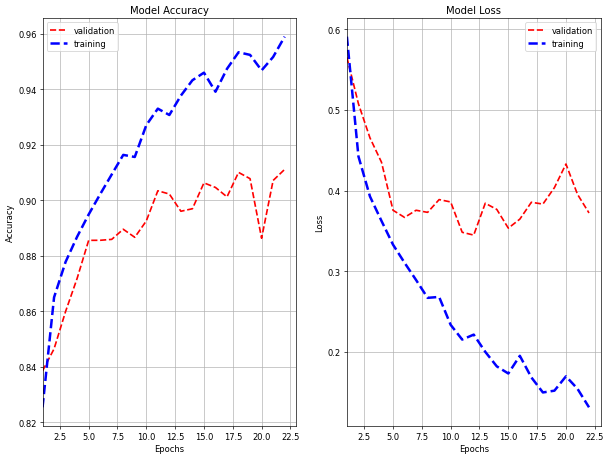

In [13]:
resolution = 512, 1024
name = "model-512-1024"
model = train_model_for_resolution(DeeplabV3PlusResnet18, name, resolution )


2022-05-01 20:36:39.251778: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-05-01 20:36:39.668537: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-01 20:36:39.669558: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-01 20:36:39.669575: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-05-01 20:36:39.669975: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-01 20:36:39.670013: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Image Accuracy 0.9079933166503906


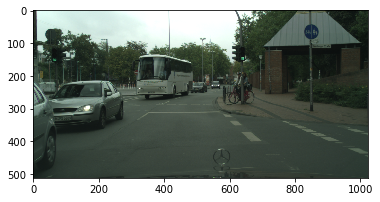

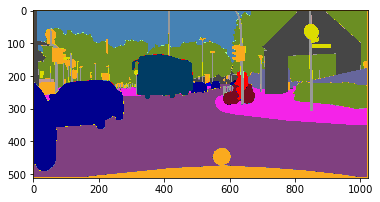

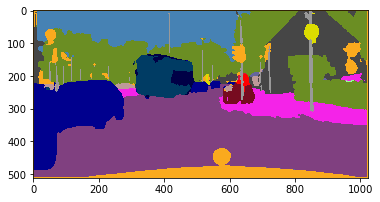

125it [00:42,  2.93it/s]


Accuracy: 0.8938323554992675
meanIoU 0.4743188


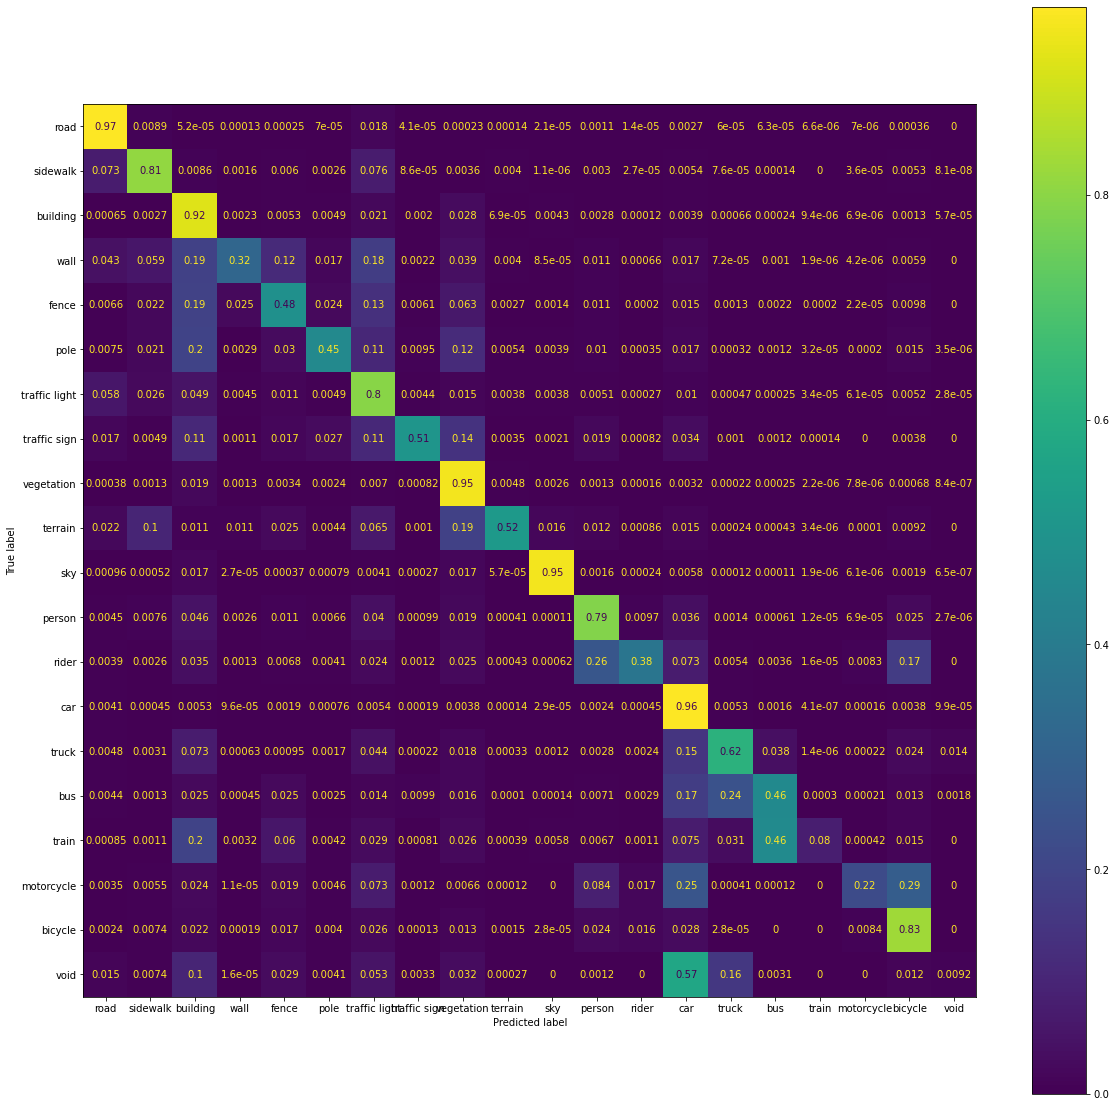

In [13]:
from tensorflow import keras
resolution =  (512, 1024)
name = "model-512-1024"
model = keras.models.load_model(name)
img = next(data_generator(test_ds, 1, resolution))
                     
predict_and_visualize(model, img)
calculate_metrics(model, test_ds, resolution)

# 256 x 512 - Resnet18

Epoch 1/100
670/670 [==============================] - 78s 110ms/step - loss: 0.6582 - accuracy: 0.8021 - val_loss: 0.6330 - val_accuracy: 0.8141
Epoch 2/100
670/670 [==============================] - 71s 106ms/step - loss: 0.5127 - accuracy: 0.8425 - val_loss: 0.5840 - val_accuracy: 0.8185
Epoch 3/100
670/670 [==============================] - 70s 104ms/step - loss: 0.4635 - accuracy: 0.8547 - val_loss: 0.4900 - val_accuracy: 0.8500
Epoch 4/100
670/670 [==============================] - 70s 105ms/step - loss: 0.4278 - accuracy: 0.8643 - val_loss: 0.6156 - val_accuracy: 0.8257
Epoch 5/100
670/670 [==============================] - 69s 104ms/step - loss: 0.3981 - accuracy: 0.8731 - val_loss: 0.4554 - val_accuracy: 0.8586
Epoch 6/100
670/670 [==============================] - 70s 104ms/step - loss: 0.3880 - accuracy: 0.8758 - val_loss: 0.4443 - val_accuracy: 0.8632
Epoch 7/100
670/670 [==============================] - 73s 110ms/step - loss: 0.3457 - accuracy: 0.8896 - val_loss: 0.4260 -

INFO:tensorflow:Assets written to: model-256-512/assets
/home/vuran/prashant/.conda/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
125it [00:21,  5.71it/s]


Accuracy: 0.8676295013427734
meanIoU 0.4356629


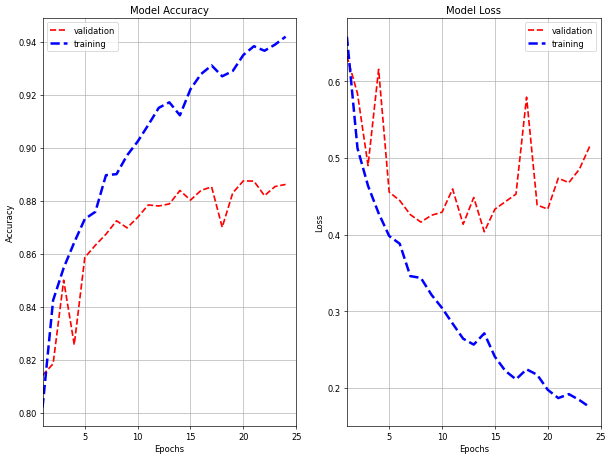

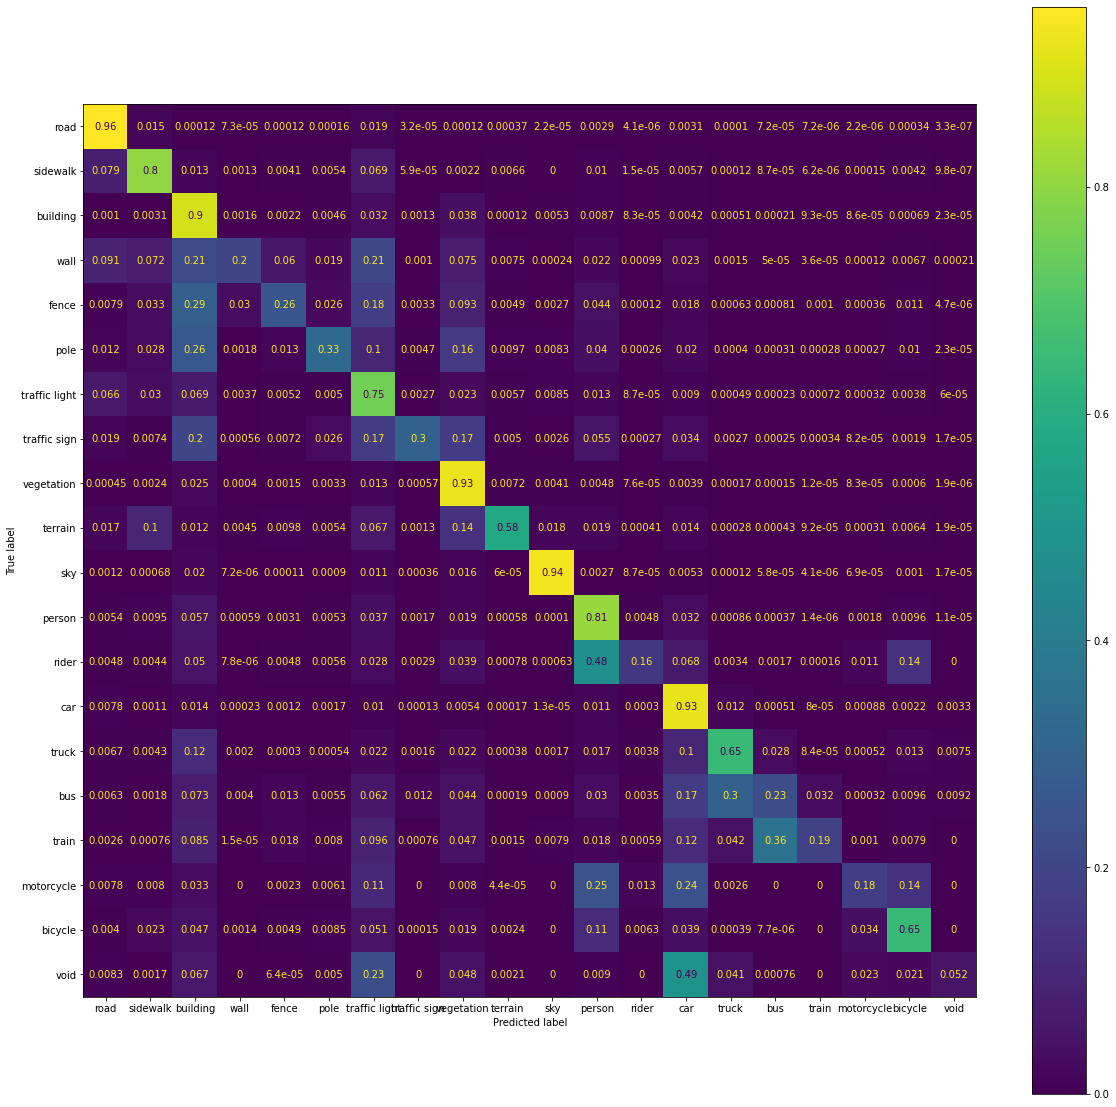

In [14]:
resolution = 256, 512
name = "model-256-512"
model = train_model_for_resolution(DeeplabV3PlusResnet18, name, resolution )
calculate_metrics(model,test_ds, resolution)

Image Accuracy 0.88421630859375


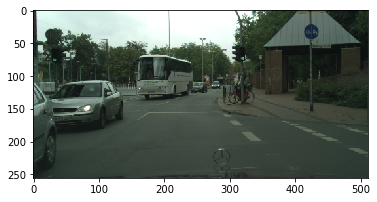

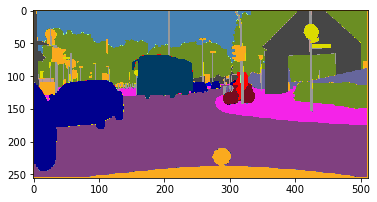

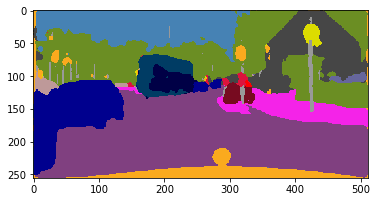

In [29]:
from tensorflow import keras
resolution = 256, 512
name = "model-256-512"

model = keras.models.load_model(name)
img = next(data_generator(test_ds, 1, resolution))
                     
predict_and_visualize(model, img)

# 128 x 256 - Resnet18


Epoch 1/100
670/670 [==============================] - 76s 109ms/step - loss: 0.7504 - accuracy: 0.7720 - val_loss: 0.6702 - val_accuracy: 0.7910
Epoch 2/100
670/670 [==============================] - 75s 112ms/step - loss: 0.6066 - accuracy: 0.8107 - val_loss: 0.6384 - val_accuracy: 0.8041
Epoch 3/100
670/670 [==============================] - 73s 109ms/step - loss: 0.5621 - accuracy: 0.8226 - val_loss: 0.5516 - val_accuracy: 0.8280
Epoch 4/100
670/670 [==============================] - 73s 109ms/step - loss: 0.5232 - accuracy: 0.8333 - val_loss: 0.5492 - val_accuracy: 0.8344
Epoch 5/100
670/670 [==============================] - 70s 105ms/step - loss: 0.4917 - accuracy: 0.8420 - val_loss: 0.5387 - val_accuracy: 0.8365
Epoch 6/100
670/670 [==============================] - 71s 106ms/step - loss: 0.4698 - accuracy: 0.8485 - val_loss: 0.5957 - val_accuracy: 0.8191
Epoch 7/100
670/670 [==============================] - 72s 108ms/step - loss: 0.4494 - accuracy: 0.8550 - val_loss: 0.5525 -

INFO:tensorflow:Assets written to: model-128-256/assets
/home/vuran/prashant/.conda/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
125it [00:16,  7.66it/s]


Accuracy: 0.8351475219726563
meanIoU 0.3658948


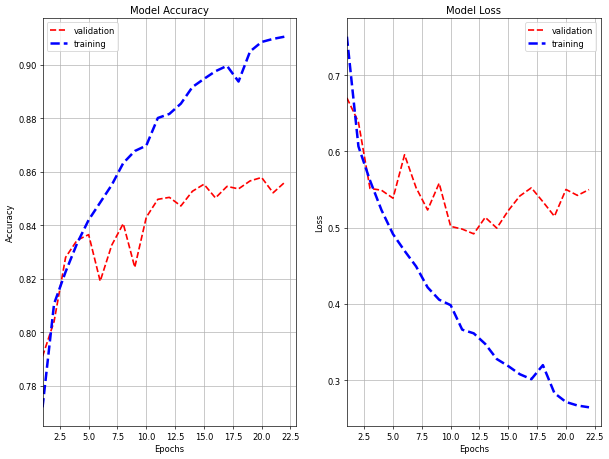

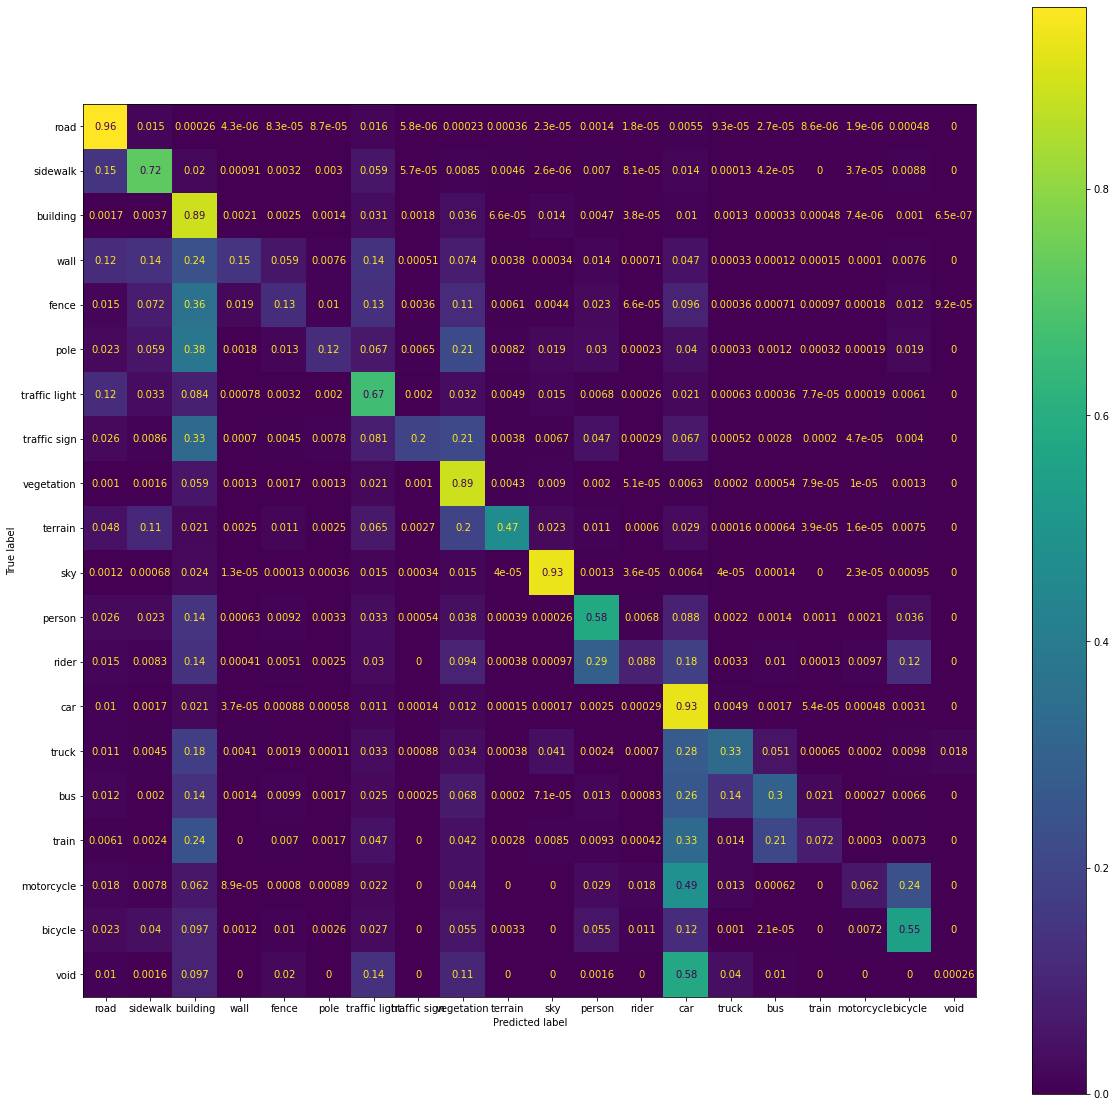

In [66]:
resolution = 128, 256
name = "model-128-256"
model = train_model_for_resolution(DeeplabV3PlusResnet18, name, resolution )
calculate_metrics(model,test_ds, resolution)

# 128 x 256 - Resnet50

Image Accuracy 0.836700439453125


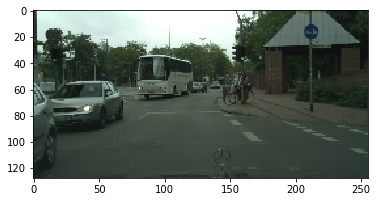

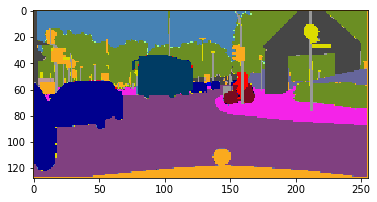

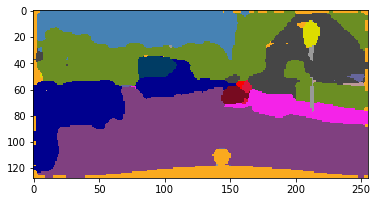

In [68]:
from tensorflow import keras
resolution = 128, 256
name = "model-128-256"

model = keras.models.load_model(name)
img = next(data_generator(test_ds, 1, resolution))
                     
predict_and_visualize(model, img)

Epoch 1/100
670/670 [==============================] - 74s 104ms/step - loss: 0.7299 - accuracy: 0.7776 - val_loss: 0.8372 - val_accuracy: 0.7624
Epoch 2/100
670/670 [==============================] - 69s 103ms/step - loss: 0.6096 - accuracy: 0.8109 - val_loss: 0.6521 - val_accuracy: 0.8002
Epoch 3/100
670/670 [==============================] - 71s 106ms/step - loss: 0.5628 - accuracy: 0.8242 - val_loss: 0.6490 - val_accuracy: 0.8017
Epoch 4/100
670/670 [==============================] - 70s 104ms/step - loss: 0.5357 - accuracy: 0.8309 - val_loss: 0.7941 - val_accuracy: 0.7517
Epoch 5/100
670/670 [==============================] - 68s 102ms/step - loss: 0.5075 - accuracy: 0.8380 - val_loss: 0.5866 - val_accuracy: 0.8158
Epoch 6/100
670/670 [==============================] - 69s 103ms/step - loss: 0.4925 - accuracy: 0.8421 - val_loss: 1.0977 - val_accuracy: 0.6469
Epoch 7/100
670/670 [==============================] - 72s 108ms/step - loss: 0.4523 - accuracy: 0.8540 - val_loss: 1.7356 -

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



670/670 [==============================] - 69s 104ms/step - loss: 0.3785 - accuracy: 0.8762 - val_loss: 0.5824 - val_accuracy: 0.8278
Epoch 14/100
670/670 [==============================] - 70s 104ms/step - loss: 0.3686 - accuracy: 0.8790 - val_loss: 0.6493 - val_accuracy: 0.8081
Epoch 15/100
670/670 [==============================] - 69s 103ms/step - loss: 0.3553 - accuracy: 0.8832 - val_loss: 0.5496 - val_accuracy: 0.8343
Epoch 16/100
670/670 [==============================] - 72s 108ms/step - loss: 0.3424 - accuracy: 0.8873 - val_loss: 0.5162 - val_accuracy: 0.8523
Epoch 17/100
670/670 [==============================] - 72s 107ms/step - loss: 0.3229 - accuracy: 0.8933 - val_loss: 0.5338 - val_accuracy: 0.8481
Epoch 18/100
670/670 [==============================] - 70s 104ms/step - loss: 0.3125 - accuracy: 0.8962 - val_loss: 0.5423 - val_accuracy: 0.8439
Epoch 19/100
670/670 [==============================] - 70s 105ms/step - loss: 0.3117 - accuracy: 0.8965 - val_loss: 0.5743 - val_a

INFO:tensorflow:Assets written to: model-128-256-resnet-50/assets
/home/vuran/prashant/.conda/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
125it [00:17,  7.00it/s]


Accuracy: 0.8366619262695313
meanIoU 0.36862525


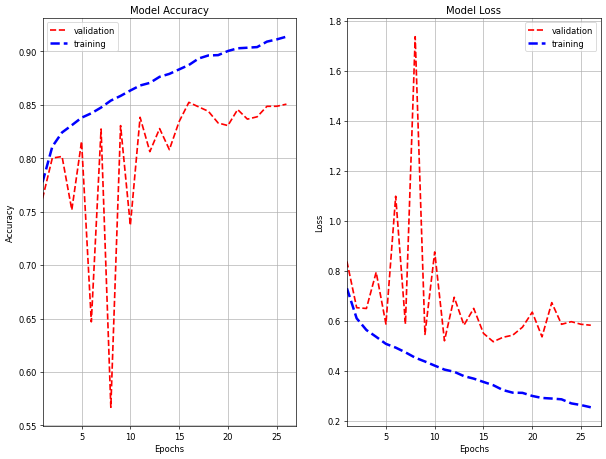

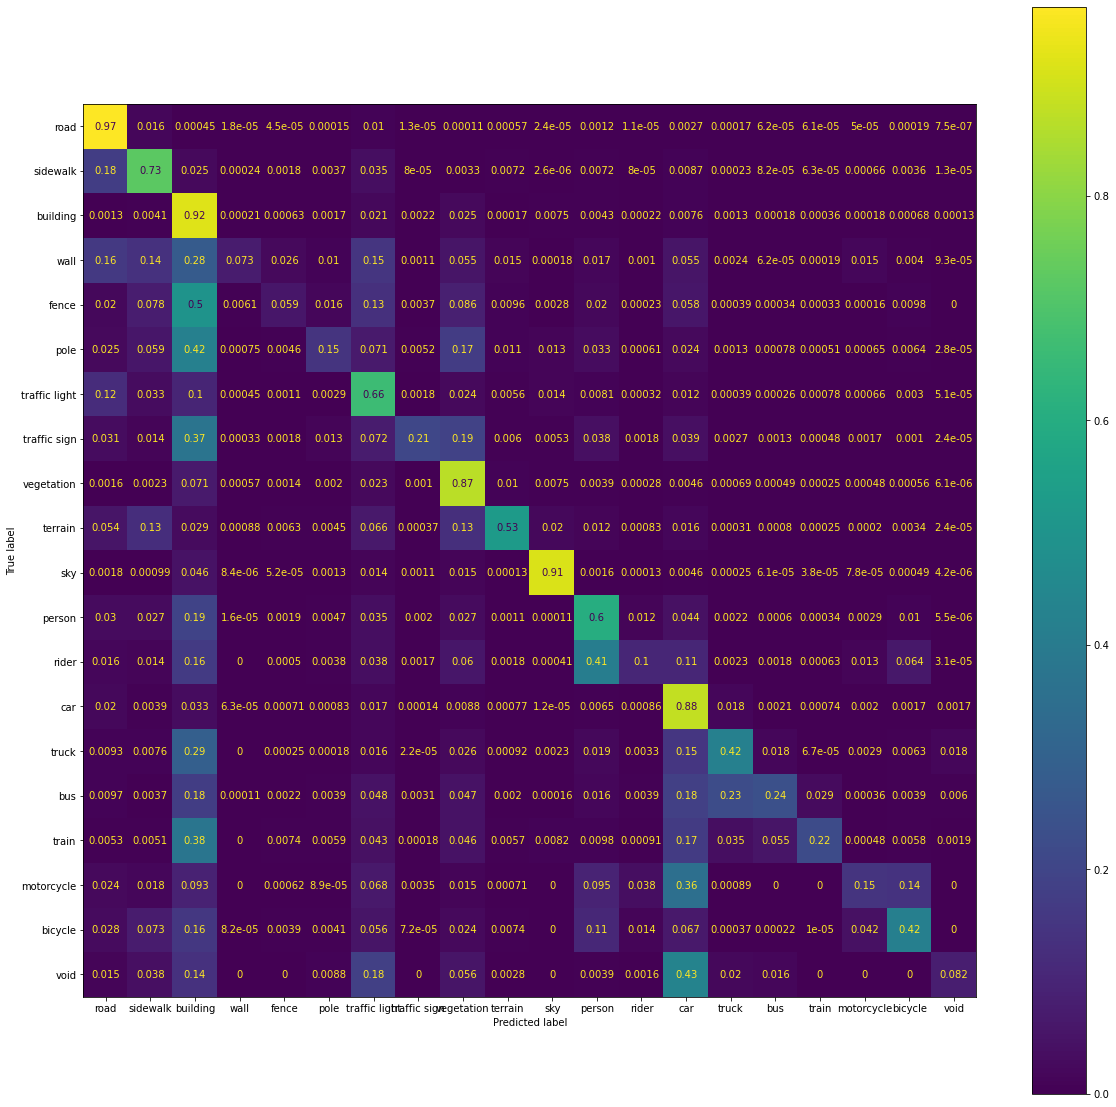

In [28]:
resolution = 128, 256
name = "model-128-256-resnet-50"
model = train_model_for_resolution(DeeplabV3PlusResnet50, name, resolution )
calculate_metrics(model,test_ds, resolution)

Image Accuracy 0.8677978515625


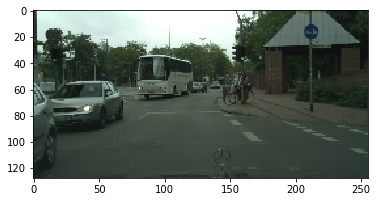

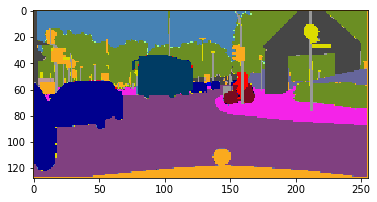

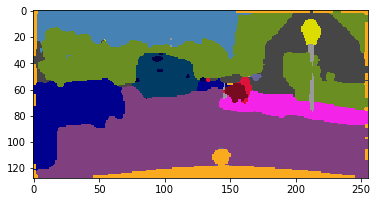

In [32]:
from tensorflow import keras
resolution = 128, 256
name = "model-128-256-resnet-50"

model = keras.models.load_model(name)
img = next(data_generator(test_ds, 1, resolution))
                     
predict_and_visualize(model, img)

# 256 x 512 - Resnet50

Epoch 1/100
670/670 [==============================] - 98s 134ms/step - loss: 0.6654 - accuracy: 0.8021 - val_loss: 0.9351 - val_accuracy: 0.7402
Epoch 2/100
670/670 [==============================] - 85s 127ms/step - loss: 0.5294 - accuracy: 0.8382 - val_loss: 0.7060 - val_accuracy: 0.7839
Epoch 3/100
670/670 [==============================] - 85s 127ms/step - loss: 0.4839 - accuracy: 0.8496 - val_loss: 0.5825 - val_accuracy: 0.8262
Epoch 4/100
670/670 [==============================] - 85s 127ms/step - loss: 0.4534 - accuracy: 0.8583 - val_loss: 0.4861 - val_accuracy: 0.8519
Epoch 5/100
670/670 [==============================] - 85s 127ms/step - loss: 0.4194 - accuracy: 0.8670 - val_loss: 0.4765 - val_accuracy: 0.8527
Epoch 6/100
670/670 [==============================] - 85s 128ms/step - loss: 0.3992 - accuracy: 0.8724 - val_loss: 0.5975 - val_accuracy: 0.8330
Epoch 7/100
670/670 [==============================] - 85s 126ms/step - loss: 0.3846 - accuracy: 0.8776 - val_loss: 0.4934 -

INFO:tensorflow:Assets written to: model-256-512-resnet-50/assets
/home/vuran/prashant/.conda/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
125it [00:24,  5.01it/s]


Accuracy: 0.865846450805664
meanIoU 0.44315785


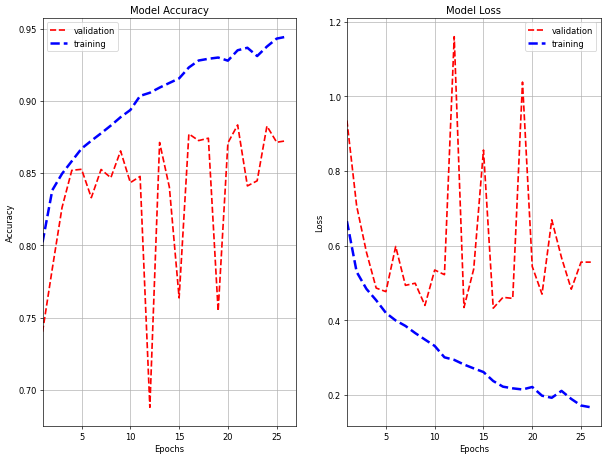

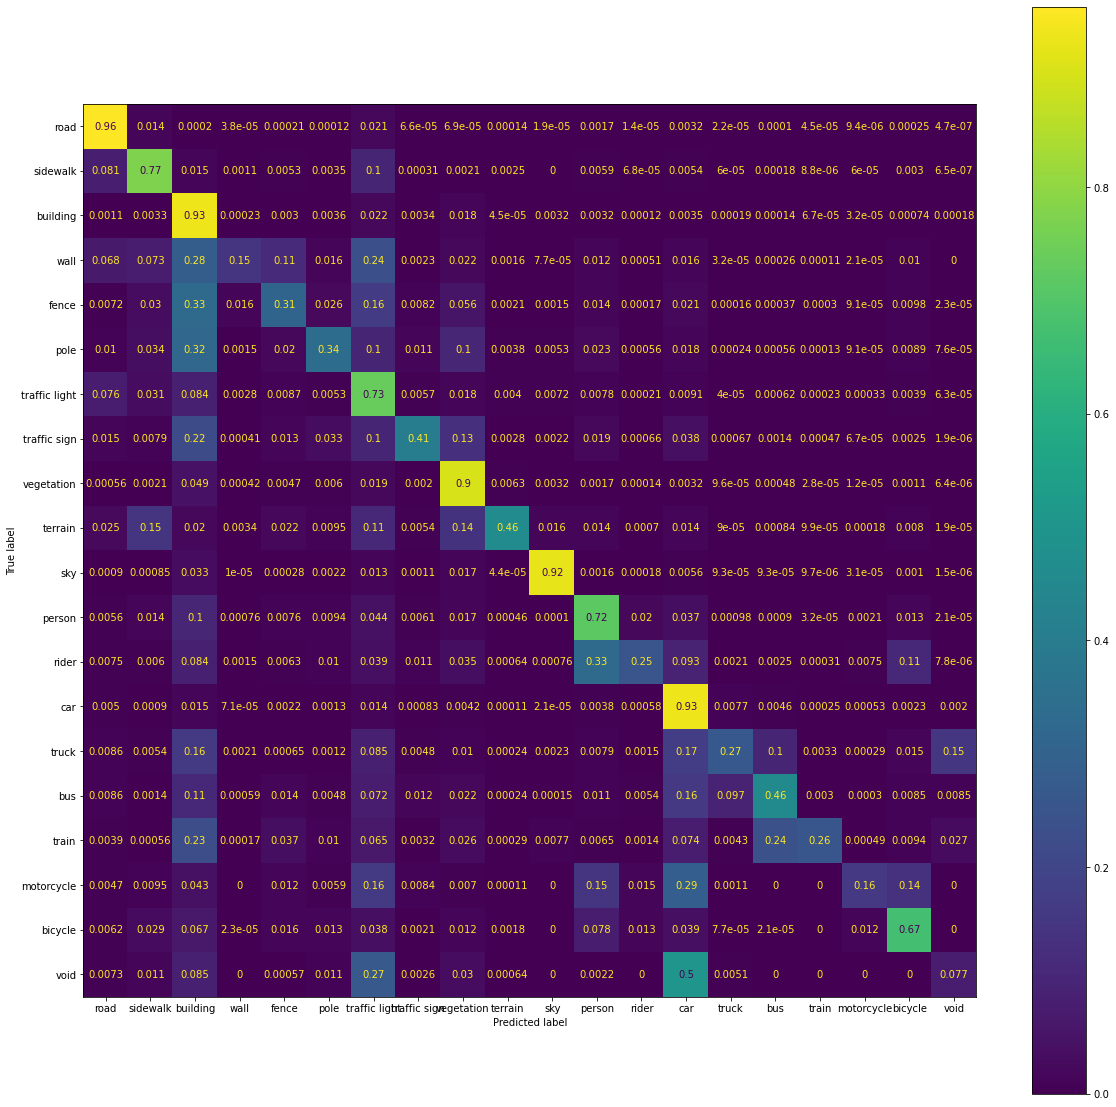

In [ ]:
resolution = 256, 512
name = "model-256-512-resnet-50"
model = train_model_for_resolution(DeeplabV3PlusResnet50, name, resolution )
calculate_metrics(model,test_ds, resolution)

Image Accuracy 0.9024887084960938


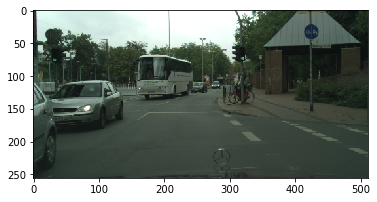

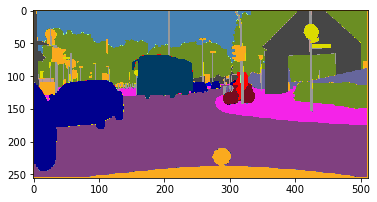

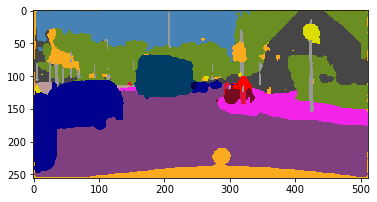

In [33]:
from tensorflow import keras
resolution = 256, 512
name = "model-256-512-resnet-50"

model = keras.models.load_model(name)
img = next(data_generator(test_ds, 1, resolution))
                     
predict_and_visualize(model, img)

# 512 x 1024 - Resnet50

Epoch 1/100


2022-05-02 09:37:06.440952: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-05-02 09:37:07.309506: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-02 09:37:07.310936: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-02 09:37:07.310951: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-05-02 09:37:07.311407: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-02 09:37:07.311441: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


670/670 [==============================] - 237s 331ms/step - loss: 0.6003 - accuracy: 0.8241 - val_loss: 0.8154 - val_accuracy: 0.7954
Epoch 2/100
670/670 [==============================] - 214s 320ms/step - loss: 0.4635 - accuracy: 0.8599 - val_loss: 0.5605 - val_accuracy: 0.8272
Epoch 3/100
670/670 [==============================] - 215s 320ms/step - loss: 0.4042 - accuracy: 0.8756 - val_loss: 0.4632 - val_accuracy: 0.8592
Epoch 4/100
670/670 [==============================] - 214s 320ms/step - loss: 0.3704 - accuracy: 0.8843 - val_loss: 0.4357 - val_accuracy: 0.8674
Epoch 5/100
670/670 [==============================] - 214s 320ms/step - loss: 0.3486 - accuracy: 0.8905 - val_loss: 0.4513 - val_accuracy: 0.8582
Epoch 6/100
670/670 [==============================] - 214s 320ms/step - loss: 0.3187 - accuracy: 0.8993 - val_loss: 0.6095 - val_accuracy: 0.8357
Epoch 7/100
670/670 [==============================] - 214s 320ms/step - loss: 0.3011 - accuracy: 0.9051 - val_loss: 0.9647 - val_

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



670/670 [==============================] - 214s 319ms/step - loss: 0.2026 - accuracy: 0.9367 - val_loss: 0.4010 - val_accuracy: 0.8835
Epoch 13/100
670/670 [==============================] - 214s 320ms/step - loss: 0.1869 - accuracy: 0.9418 - val_loss: 0.4566 - val_accuracy: 0.8760
Epoch 14/100
670/670 [==============================] - 214s 320ms/step - loss: 0.2085 - accuracy: 0.9344 - val_loss: 0.3867 - val_accuracy: 0.8945
Epoch 15/100
670/670 [==============================] - 214s 320ms/step - loss: 0.1680 - accuracy: 0.9477 - val_loss: 0.5535 - val_accuracy: 0.8517
Epoch 16/100
670/670 [==============================] - 214s 320ms/step - loss: 0.1632 - accuracy: 0.9491 - val_loss: 0.3578 - val_accuracy: 0.9077
Epoch 17/100
670/670 [==============================] - 215s 320ms/step - loss: 0.1531 - accuracy: 0.9523 - val_loss: 0.4897 - val_accuracy: 0.8829
Epoch 18/100
670/670 [==============================] - 214s 320ms/step - loss: 0.1672 - accuracy: 0.9477 - val_loss: 0.4134 

2022-05-02 11:10:21.868490: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model-512-1024-resnet-50/assets


INFO:tensorflow:Assets written to: model-512-1024-resnet-50/assets
/home/vuran/prashant/.conda/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
125it [00:46,  2.69it/s]


Accuracy: 0.8953883514404297
meanIoU 0.49090153


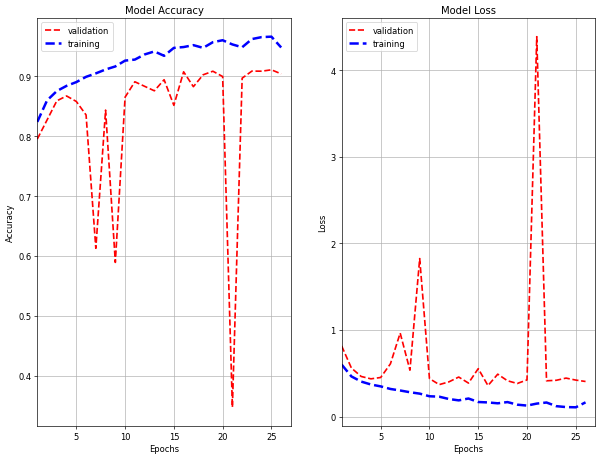

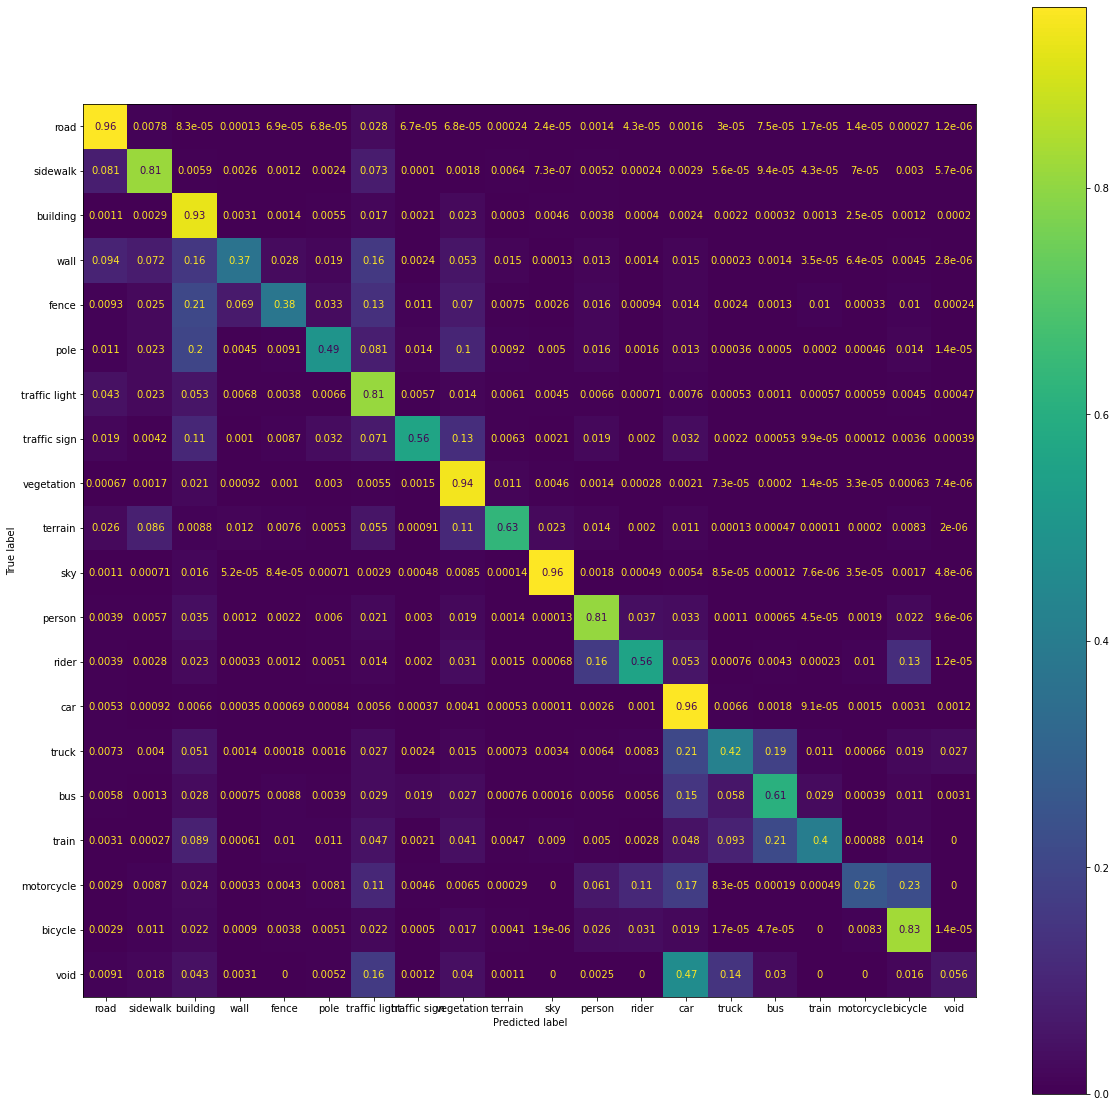

In [13]:
resolution = 512, 1024
name = "model-512-1024-resnet-50"
model = train_model_for_resolution(DeeplabV3PlusResnet50, name, resolution )
calculate_metrics(model,test_ds, resolution)

Image Accuracy 0.8992347717285156


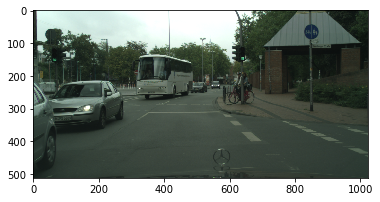

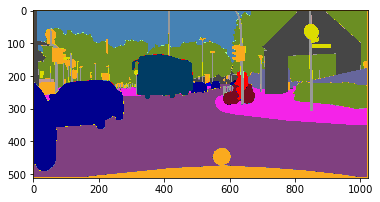

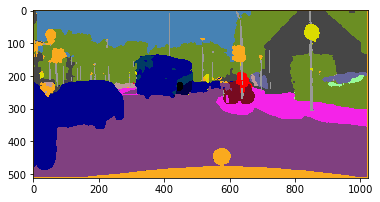

In [37]:
from tensorflow import keras
resolution = 512, 1024
name = "model-512-1024-resnet-50"

model = keras.models.load_model(name)
img = next(data_generator(test_ds, 1, resolution))
                     
predict_and_visualize(model, img)

# Bench mark to understand how much time each loop added to training time

In [62]:
%%timeit
for i in data_generator(test_ds, 1, (512, 1024)):
    pass

10.5 s ± 69.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
%%timeit
for i in data_generator(test_ds, 1, (256, 512)):
    pass

10.4 s ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [65]:
%%timeit
for i in data_generator(test_ds, 1, (128, 256)):
    pass

10.3 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
